# Training Your Model in PyTorch
## Introduction
In past videos, we've discussed and demonstrated:
* Building models with the neural network layers and functions of the torch.nn module
* The mechanics of automated gradient computation, which is central to gradient-based model training
* Using TensorBoard to visualize training progress and other activities

In this video, we'll be adding some new tools to your inventory:
* We'll get familiar with the dataset and dataloader abstractions, and how they ease the process of feeding data to your model during a training loop
* We'll discuss specific loss functions and when to use them
* We'll look at PyTorch optimizers, which implement algorithms to adjust model weights based on the outcome of a loss function

Finally, we'll pull all of these together and see a full PyTorch training loop in action.

## Dataset and DataLoader

The `Dataset` and `DataLoader` classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The `Dataset` is responsible for accessing and processing single instances of data.

The `DataLoader` pulls instances of data from the `Dataset` (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The `DataLoader` works with all kinds of datasets, regardless of the type of data they contain.

For this tutorial, we'll be using the Fashion-MNIST dataset provided by TorchVision. We use `torchvision.transforms.Normalize()` to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from ADDA.data import augmentations
import ADDA
import torch
import matplotlib.pyplot as plt
# PyTorch TensorBoard support
#from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

train_transform, test_transform = augmentations.supervised_augmentations()

In [2]:
model_f_train_data_path = "I_train.npy"
model_f_train_labels_path = "I_train_label.npy"

model_f_test_data_path = "I_test.npy"#val
model_f_test_labels_path =  "I_test_label.npy"

model_f_test2_data_path = "I_test2.npy"#test
model_f_test2_labels_path =  "I_test2_label.npy"
# target domain: model_j
model_j_train_data_path = "II_train.npy"
model_j_train_labels_path ="II_train_label.npy"

model_j_test_data_path = "II_test.npy"
model_j_test_labels_path = "II_test_label.npy"

model_j_test2_data_path = "III_test2.npy"
model_j_test2_labels_path =  "II_test2_label.npy"
# test domain: model_k
model_k_train_data_path = "III_train.npy"
model_k_train_labels_path ="II_train_label.npy"

model_k_test_data_path = "III_test.npy"
model_k_test_labels_path = "III_test_label.npy"

model_k_test2_data_path = "III_test2.npy"
model_k_test2_labels_path =  "III_test2_label.npy"

In [3]:
from ADDA.data.dataset import get_dataloader

bs =100

source_dataloader = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform, bs)
source_dataloader_test = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)
source_dataloader_test2 = get_dataloader(model_f_test2_data_path, model_f_test2_labels_path, test_transform, bs)

target_dataloader_test2 = get_dataloader(model_j_test2_data_path, model_j_test2_labels_path, test_transform, bs)
test_dataloader_test2 = get_dataloader(model_k_test2_data_path, model_k_test2_labels_path, test_transform, bs)

As always, let's visualize the data as a sanity check:

In [4]:
from ADDA.data import hyperparams

hparams = hyperparams.supervised_hyperparams(wd=5e-5)

## The Model

The model we'll use in this example is a variant of LeNet-5 - it should be familiar if you've watched the previous videos in this series.

In [38]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2304, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Optimizer

For this example, we'll be using simple [stochastic gradient descent](https://pytorch.org/docs/stable/optim.html) with momentum.

It can be instructive to try some variations on this optimization scheme:
* Learning rate determines the size of the steps the optimizer takes. What does a different learning rate do to the your training results, in terms of accuracy and convergence time?
* Momentum nudges the optimizer in the direction of strongest gradient over multiple steps. What does changing this value do to your results?
* Try some different optimization algorithms, such as averaged SGD, Adagrad, or Adam. How do your results differ?

In [39]:
num_classes = 3
num_epochs = 50
batch_size = 16
learning_rate = 1e-3

model = AlexNet(num_classes).to('cuda' )


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(source_dataloader)

## The Training Loop

Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:
* Gets a batch of training data from the DataLoader
* Zeros the optimizer's gradients
* Performs an inference - that is, gets predictions from the model for an input batch
* Calculates the loss for that set of predictions vs. the labels on the dataset
* Calculates the backward gradients over the learning weights
* Tells the optimizer to perform one learning step - that is, adjust the model's learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
* It reports on the loss for every 1000 batches.
* Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

### Per-Epoch Activity

There are a couple of things we'll want to do once per epoch:
* Perform validation by checking our relative loss on a set of data that was not used for training, and report this
* Save a copy of the model

Here, we'll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [40]:
from tqdm import tqdm
total_step = len(source_dataloader)
device='cuda'
for epoch in range(num_epochs):
    i=0
    for images, labels in tqdm(source_dataloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze(1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i+=1
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in source_dataloader_test:
            images = images.to(device)
            labels = labels.reshape(-1).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy  {} %'.format(100 * correct / total)) 

100%|██████████| 90/90 [00:32<00:00,  2.73it/s]

Epoch [1/50], Step [91/90], Loss: 1.0913


Accuracy  36.27777777777778 %


100%|██████████| 90/90 [00:03<00:00, 28.41it/s]

Epoch [2/50], Step [91/90], Loss: 1.0631


Accuracy  36.05555555555556 %


100%|██████████| 90/90 [00:03<00:00, 29.70it/s]

Epoch [3/50], Step [91/90], Loss: 1.0183


Accuracy  44.5 %


100%|██████████| 90/90 [00:03<00:00, 29.73it/s]

Epoch [4/50], Step [91/90], Loss: 0.8375


Accuracy  59.44444444444444 %


100%|██████████| 90/90 [00:03<00:00, 29.64it/s]

Epoch [5/50], Step [91/90], Loss: 0.6699


Accuracy  65.16666666666667 %


100%|██████████| 90/90 [00:03<00:00, 29.86it/s]

Epoch [6/50], Step [91/90], Loss: 0.6342


Accuracy  71.77777777777777 %


100%|██████████| 90/90 [00:02<00:00, 30.03it/s]

Epoch [7/50], Step [91/90], Loss: 0.5644


Accuracy  61.72222222222222 %


100%|██████████| 90/90 [00:03<00:00, 29.73it/s]

Epoch [8/50], Step [91/90], Loss: 0.5192


Accuracy  76.38888888888889 %


100%|██████████| 90/90 [00:02<00:00, 30.08it/s]

Epoch [9/50], Step [91/90], Loss: 0.4392


Accuracy  78.44444444444444 %


100%|██████████| 90/90 [00:03<00:00, 29.84it/s]

Epoch [10/50], Step [91/90], Loss: 0.4967


Accuracy  76.5 %


100%|██████████| 90/90 [00:03<00:00, 29.68it/s]

Epoch [11/50], Step [91/90], Loss: 0.6129


Accuracy  76.94444444444444 %


100%|██████████| 90/90 [00:03<00:00, 29.99it/s]

Epoch [12/50], Step [91/90], Loss: 0.4826


Accuracy  77.44444444444444 %


100%|██████████| 90/90 [00:02<00:00, 30.46it/s]

Epoch [13/50], Step [91/90], Loss: 0.4012


Accuracy  75.16666666666667 %


100%|██████████| 90/90 [00:02<00:00, 30.34it/s]

Epoch [14/50], Step [91/90], Loss: 0.3593


Accuracy  76.88888888888889 %


100%|██████████| 90/90 [00:03<00:00, 29.84it/s]

Epoch [15/50], Step [91/90], Loss: 0.4974


Accuracy  78.16666666666667 %


100%|██████████| 90/90 [00:03<00:00, 29.94it/s]

Epoch [16/50], Step [91/90], Loss: 0.5083


Accuracy  79.0 %


100%|██████████| 90/90 [00:02<00:00, 30.23it/s]

Epoch [17/50], Step [91/90], Loss: 0.3434


Accuracy  77.27777777777777 %


100%|██████████| 90/90 [00:03<00:00, 29.62it/s]

Epoch [18/50], Step [91/90], Loss: 0.4400


Accuracy  76.66666666666667 %


100%|██████████| 90/90 [00:03<00:00, 29.55it/s]

Epoch [19/50], Step [91/90], Loss: 0.4963


Accuracy  70.38888888888889 %


100%|██████████| 90/90 [00:03<00:00, 29.42it/s]

Epoch [20/50], Step [91/90], Loss: 0.3788


Accuracy  79.66666666666667 %


100%|██████████| 90/90 [00:03<00:00, 29.66it/s]

Epoch [21/50], Step [91/90], Loss: 0.4842


Accuracy  79.61111111111111 %


100%|██████████| 90/90 [00:03<00:00, 29.50it/s]

Epoch [22/50], Step [91/90], Loss: 0.4632


Accuracy  79.5 %


100%|██████████| 90/90 [00:03<00:00, 29.37it/s]

Epoch [23/50], Step [91/90], Loss: 0.3811


Accuracy  80.55555555555556 %


100%|██████████| 90/90 [00:03<00:00, 29.16it/s]

Epoch [24/50], Step [91/90], Loss: 0.2969


Accuracy  82.55555555555556 %


100%|██████████| 90/90 [00:03<00:00, 29.48it/s]

Epoch [25/50], Step [91/90], Loss: 0.3646


Accuracy  78.94444444444444 %


100%|██████████| 90/90 [00:03<00:00, 29.78it/s]

Epoch [26/50], Step [91/90], Loss: 0.3664


Accuracy  79.44444444444444 %


100%|██████████| 90/90 [00:03<00:00, 29.76it/s]

Epoch [27/50], Step [91/90], Loss: 0.4614


Accuracy  75.88888888888889 %


100%|██████████| 90/90 [00:03<00:00, 29.88it/s]

Epoch [28/50], Step [91/90], Loss: 0.2931


Accuracy  81.33333333333333 %


100%|██████████| 90/90 [00:03<00:00, 29.65it/s]

Epoch [29/50], Step [91/90], Loss: 0.3650


Accuracy  82.11111111111111 %


100%|██████████| 90/90 [00:03<00:00, 29.76it/s]

Epoch [30/50], Step [91/90], Loss: 0.3074


Accuracy  82.94444444444444 %


100%|██████████| 90/90 [00:02<00:00, 30.27it/s]

Epoch [31/50], Step [91/90], Loss: 0.5135


Accuracy  76.27777777777777 %


100%|██████████| 90/90 [00:02<00:00, 30.03it/s]

Epoch [32/50], Step [91/90], Loss: 0.4008


Accuracy  82.72222222222223 %


100%|██████████| 90/90 [00:02<00:00, 30.33it/s]

Epoch [33/50], Step [91/90], Loss: 0.3064


Accuracy  82.38888888888889 %


100%|██████████| 90/90 [00:02<00:00, 30.17it/s]

Epoch [34/50], Step [91/90], Loss: 0.3130


Accuracy  81.5 %


100%|██████████| 90/90 [00:02<00:00, 30.35it/s]

Epoch [35/50], Step [91/90], Loss: 0.3316


Accuracy  83.11111111111111 %


100%|██████████| 90/90 [00:02<00:00, 30.42it/s]

Epoch [36/50], Step [91/90], Loss: 0.3748


Accuracy  84.72222222222223 %


100%|██████████| 90/90 [00:02<00:00, 30.22it/s]

Epoch [37/50], Step [91/90], Loss: 0.3537


Accuracy  84.5 %


100%|██████████| 90/90 [00:03<00:00, 29.58it/s]

Epoch [38/50], Step [91/90], Loss: 0.1958


Accuracy  83.5 %


100%|██████████| 90/90 [00:03<00:00, 29.76it/s]

Epoch [39/50], Step [91/90], Loss: 0.3729


Accuracy  80.55555555555556 %


100%|██████████| 90/90 [00:03<00:00, 29.85it/s]

Epoch [40/50], Step [91/90], Loss: 0.4143


Accuracy  83.5 %


100%|██████████| 90/90 [00:03<00:00, 29.80it/s]

Epoch [41/50], Step [91/90], Loss: 0.2311


Accuracy  84.55555555555556 %


100%|██████████| 90/90 [00:03<00:00, 29.84it/s]

Epoch [42/50], Step [91/90], Loss: 0.2835


Accuracy  84.83333333333333 %


100%|██████████| 90/90 [00:03<00:00, 28.82it/s]

Epoch [43/50], Step [91/90], Loss: 0.3406


Accuracy  84.11111111111111 %


100%|██████████| 90/90 [00:03<00:00, 28.65it/s]

Epoch [44/50], Step [91/90], Loss: 0.2763


Accuracy  85.27777777777777 %


100%|██████████| 90/90 [00:03<00:00, 29.30it/s]

Epoch [45/50], Step [91/90], Loss: 0.3829


Accuracy  83.33333333333333 %


100%|██████████| 90/90 [00:03<00:00, 29.27it/s]

Epoch [46/50], Step [91/90], Loss: 0.2455


Accuracy  86.38888888888889 %


100%|██████████| 90/90 [00:03<00:00, 29.54it/s]

Epoch [47/50], Step [91/90], Loss: 0.3118


Accuracy  84.11111111111111 %


100%|██████████| 90/90 [00:03<00:00, 28.35it/s]

Epoch [48/50], Step [91/90], Loss: 0.2823


Accuracy  83.5 %


100%|██████████| 90/90 [00:03<00:00, 29.11it/s]

Epoch [49/50], Step [91/90], Loss: 0.2893


Accuracy  86.44444444444444 %


100%|██████████| 90/90 [00:03<00:00, 28.60it/s]

Epoch [50/50], Step [91/90], Loss: 0.2003


Accuracy  83.5 %


In [41]:
torch.save(model.state_dict(), "AlexNet.pt")

In [50]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
def test(model,dataloader, return_lists_roc=False):
    labels_list = np.array([])
    outputs_list = np.array([])
    preds_list = np.array([])
    with torch.no_grad():
        correct = 0
        total = 0
    i=0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.reshape(-1).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i==0:
            labels_list=labels.detach().cpu().numpy()
            outputs_list=outputs.data.detach().cpu().numpy()
            preds_list=predicted.detach().cpu().numpy()
            i=1
        else:
            labels_list=np.append(labels_list,labels.detach().cpu().numpy())
            outputs_list=np.append(outputs_list,outputs.data.detach().cpu().numpy(),axis=0)
            preds_list=np.append(preds_list,predicted.detach().cpu().numpy())
    if return_lists_roc:
        return 100 * correct / total, np.array(labels_list), np.array(outputs_list),np.array(preds_list)
    else:
        return 100 * correct / total
def plot_cm_roc(self, dataloader, output_path=None, n_classes=3):
    """
    Plots the confusion matrix and ROC curves of the model on `dataloader`.

    Arguments:
    ----------
    dataloader: PyTorch DataLoader
        DataLoader with test data.

    n_classes: int
        Number of classes.

    output_path: str
        Output path to .npz (NumPy) file containing the true positive rate, false positive rate
        and AUROC.
        To obtain the information, load the .npz file with `allow_picle=True` and select the data
        of interest with `array['tpr'].item()`, `array['fpr'].item()` or `array['roc_auc'].item()`.
    """

    cmap = sns.diverging_palette(0, 255, sep=1, n=256, as_cmap=True)

    accuracy, labels_list, outputs_list, preds_list =test(model,dataloader, return_lists_roc=True)
    #labellist: true labels
    #outputs_list: predicted labels
    # plot confusion matrix
    cm = sklearn.metrics.confusion_matrix(labels_list, preds_list)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['({0:.2%})'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(n_classes,n_classes)
    #tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(4,4), dpi=200)
    categories = ['axion', 'cdm', 'no'] #  0:axion 1:cdm 2:no 
    sns.heatmap(cm, annot=labels, cmap=cmap, fmt="", xticklabels=categories, yticklabels=categories)
    plt.title("Confusion matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()
    color=['darkorange','darkblue','darkgreen']
    # plot roc
    ## one hot encode data
    label_binarizer = LabelBinarizer().fit( labels_list)
    onehot = label_binarizer.transform(labels_list)
    print(onehot.shape)
    fig, ax = plt.subplots()
    ax.set_title("One vs rest ROC curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    for class_of_interest in range(n_classes):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        plot_chance_level =False
        ## get roc curve and auroc for each class
        if class_of_interest == n_classes-1:
            plot_chance_level=True
        display = RocCurveDisplay.from_predictions(
            onehot[:, class_id],
            outputs_list[:, class_id],
            name=f"{categories[class_of_interest]} vs the rest",
            color=color[class_of_interest],
            plot_chance_level=plot_chance_level ,
            ax=ax, 
        )
   

accuracy on test set = 85.22222222222223


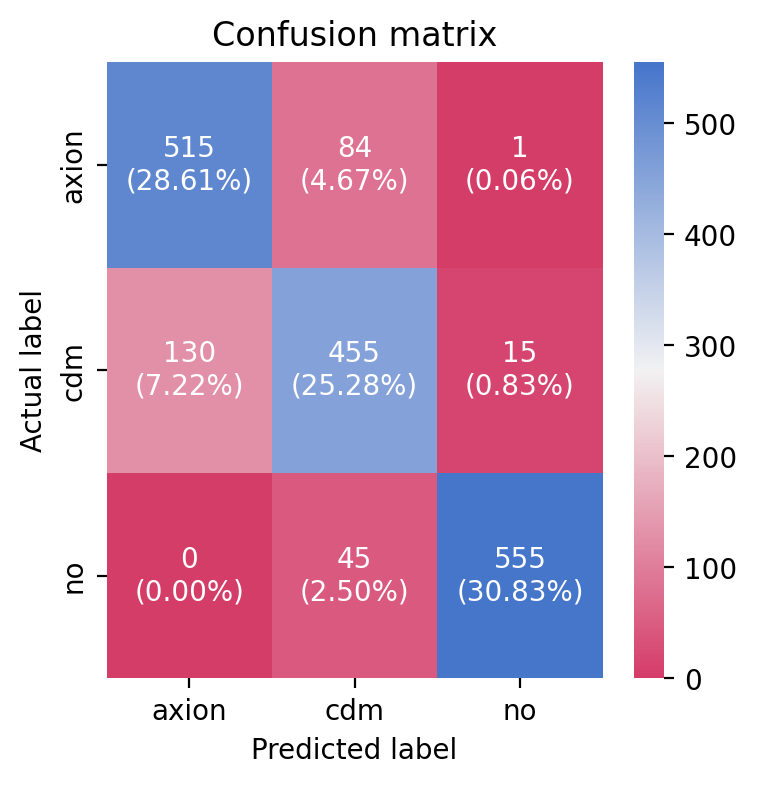

(1800, 3)


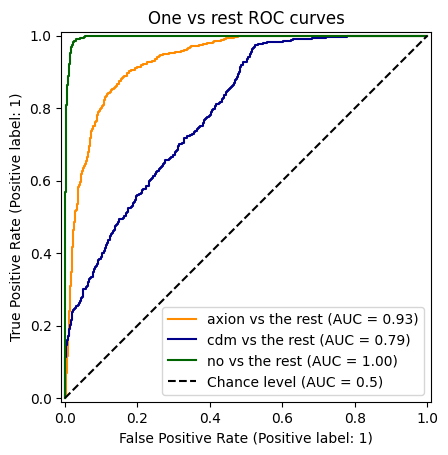

In [52]:
print(f"accuracy on test set = {test(model,source_dataloader_test2)}")
plot_cm_roc(model,source_dataloader_test2, output_path=None, n_classes=3)

accuracy on test set = 34.388888888888886


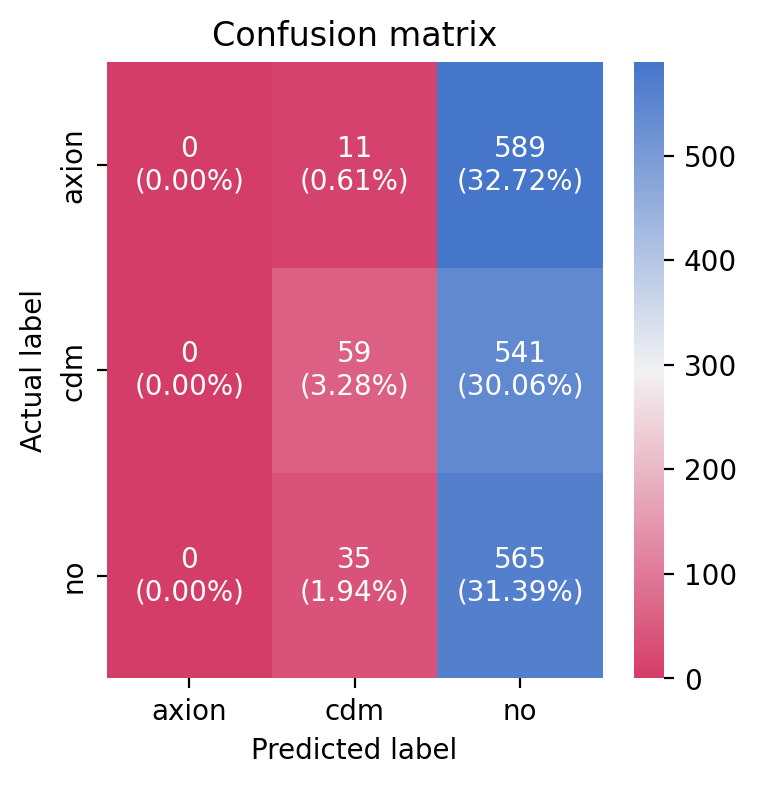

(1800, 3)


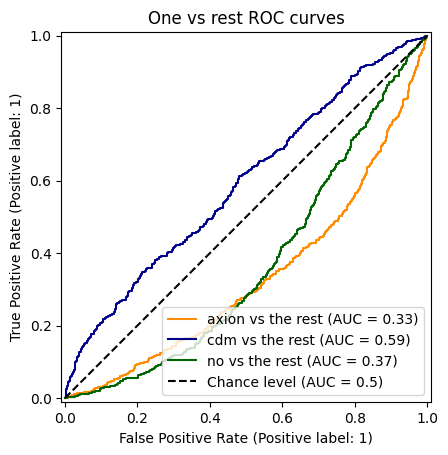

In [55]:
print(f"accuracy on test set = {test(model,target_dataloader_test2)}")
plot_cm_roc(model,target_dataloader_test2, output_path=None, n_classes=3)

accuracy on test set = 33.77777777777778


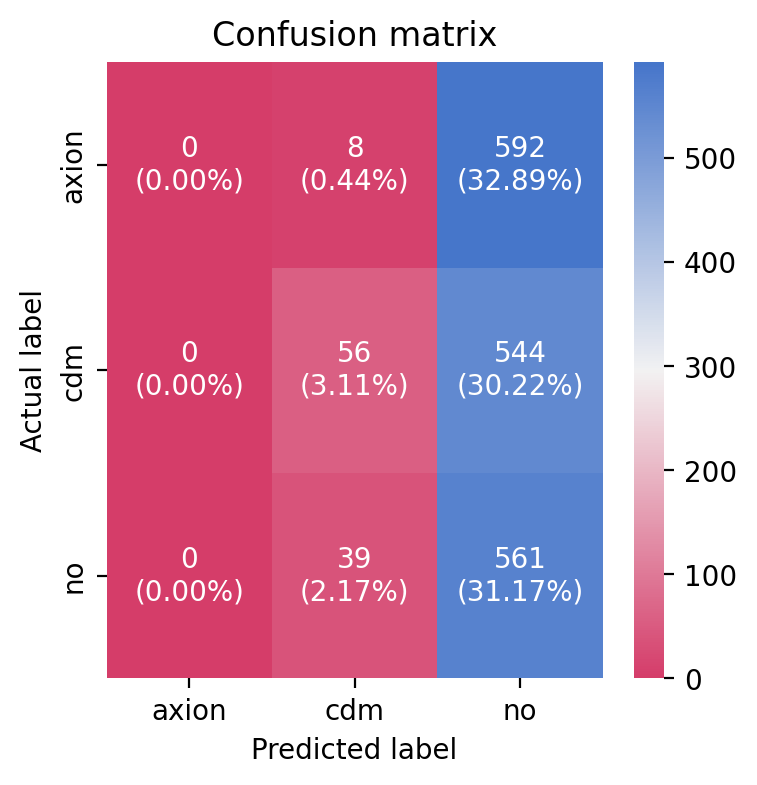

(1800, 3)


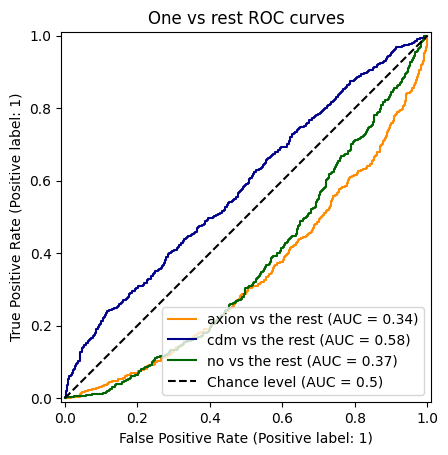

In [57]:
print(f"accuracy on test set = {test(model,test_dataloader_test2)}")
plot_cm_roc(model,test_dataloader_test2, output_path=None, n_classes=3)

To load a saved version of the model:

```
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))
```

Once you've loaded the model, it's ready for whatever you need it for - more training, inference, or analysis.

Note that if your model has constructor parameters that affect model structure, you'll need to provide them and configure the model identically to the state in which it was saved.

## Other Resources

* Docs on the [data utilities](https://pytorch.org/docs/stable/data.html), including Dataset and DataLoader, at pytorch.org
* A [note on the use of pinned memory](https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-pinning) for GPU training
* Documentation on the datasets available in [TorchVision](https://pytorch.org/docs/stable/torchvision/datasets.html), [TorchText](https://pytorch.org/text/datasets.html), and [TorchAudio](https://pytorch.org/audio/datasets.html)
* Documentation on the [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) available in PyTorch
* Documentation on the [torch.optim package](https://pytorch.org/docs/stable/optim.html), which includes optimizers and related tools, such as learning rate scheduling
* A detailed [tutorial on saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
* The [Tutorials section of pytorch.org](https://pytorch.org/tutorials/) contains tutorials on a broad variety of training tasks, including classification in different domains, generative adversarial networks, reinforcement learning, and more